<a href="https://colab.research.google.com/github/priyashixsarkar/fastag-fraud-detection/blob/main/frauddetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/Datasets/FastagFraudDetection (1).csv"

df = pd.read_csv(CSV_PATH)
df.head()


,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,1/6/2023 11:20,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud
1,2,1/7/2023 14:55,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud
2,3,1/8/2023 18:25,Motorcycle,NaN,D-104,Regular,Small,0,0,"13.059816123454882, 77.77068662374292",53,KA88EF9012,Not Fraud
3,4,1/9/2023 2:05,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,Fraud
4,5,1/10/2023 6:35,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,"13.059816123454882, 77.77068662374292",60,KA44IJ6789,Fraud


In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv(CSV_PATH)


In [12]:
df.drop_duplicates(inplace=True)


In [41]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.dayofweek

df["Hour"] = df["Hour"].fillna(0).astype(int)
df["Day"] = df["Day"].fillna(0).astype(int)


In [14]:
categorical_cols = ["Vehicle_Type", "Lane_Type", "TollBoothID", "Fraud_indicator"]

for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()


In [42]:
# Convert to numeric
df["Vehicle_Speed"] = pd.to_numeric(df["Vehicle_Speed"], errors="coerce")

# Fill missing values with median
df["Vehicle_Speed"] = df["Vehicle_Speed"].fillna(df["Vehicle_Speed"].median())


In [16]:
# Remove zero or negative speeds
df = df[df["Vehicle_Speed"] > 0]

# Optional: remove unrealistically high speeds
df = df[df["Vehicle_Speed"] < 200]


In [17]:
df["Label"] = (df["Fraud_indicator"] == "fraud").astype(int)


In [18]:
from sklearn.preprocessing import LabelEncoder

le_vehicle = LabelEncoder()
le_lane = LabelEncoder()
le_booth = LabelEncoder()

df["Vehicle_Type_enc"] = le_vehicle.fit_transform(df["Vehicle_Type"])
df["Lane_Type_enc"] = le_lane.fit_transform(df["Lane_Type"])
df["TollBoothID_enc"] = le_booth.fit_transform(df["TollBoothID"])


In [26]:
features = [
    "Hour",
    "Day",
    "Vehicle_Speed",
    "Vehicle_Type_enc",
    "Lane_Type_enc"

]

X = df[features]
y = df["Label"]



In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [29]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=3000,
    C=5.0,               # less regularization
    solver="liblinear"   # stable for small/medium datasets
)

model.fit(X_train, y_train)



LogisticRegression(C=5.0, max_iter=3000, solver='liblinear')

In [30]:
y_prob = model.predict_proba(X_test)[:, 1]

In [32]:
import numpy as np
from sklearn.metrics import accuracy_score

best_acc = 0
best_thresh = 0.5

for t in np.arange(0.55, 0.95, 0.02):
    y_pred_t = (y_prob >= t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    if acc > best_acc:
        best_acc = acc
        best_thresh = t


In [43]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [45]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred) * 100)
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))


Accuracy: 56.10000000000001
              precision    recall  f1-score   support

           0       0.84      0.56      0.67       803
           1       0.24      0.57      0.34       197

    accuracy                           0.56      1000
   macro avg       0.54      0.56      0.50      1000
weighted avg       0.72      0.56      0.61      1000

[[449 354]
 [ 85 112]]


In [44]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Train
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train_sm, y_train_sm)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.56      0.67       803
           1       0.24      0.57      0.34       197

    accuracy                           0.56      1000
   macro avg       0.54      0.56      0.50      1000
weighted avg       0.72      0.56      0.61      1000

[[449 354]
 [ 85 112]]


In [46]:
y_prob = model.predict_proba(X_test)[:, 1]


**Confusion Matrix**

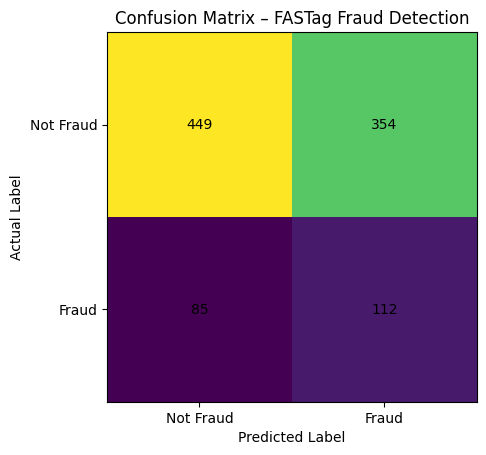

In [49]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix – FASTag Fraud Detection")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.xticks([0, 1], ["Not Fraud", "Fraud"])
plt.yticks([0, 1], ["Not Fraud", "Fraud"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i][j], ha="center", va="center")

plt.show()


**ROC Curve (Receiver Operating Characteristic)**
Shows how well the model separates Fraud vs Not Fraud.

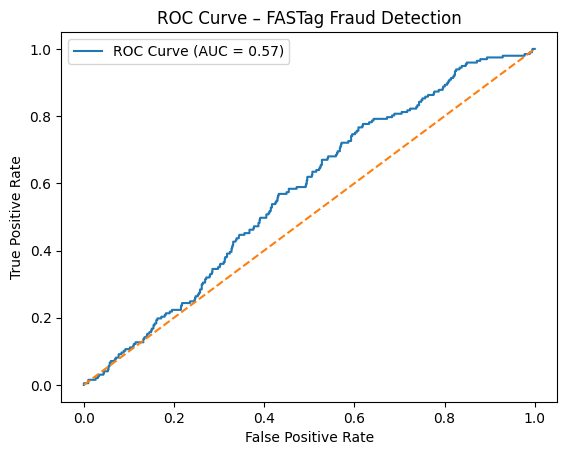

In [48]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – FASTag Fraud Detection")
plt.legend()
plt.show()



**Precision–Recall Curve**

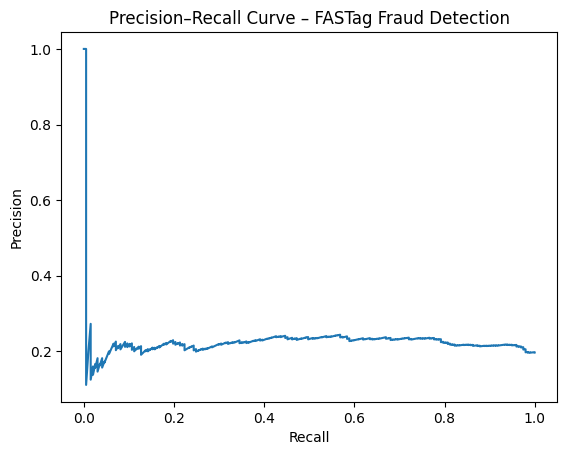

In [50]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – FASTag Fraud Detection")
plt.show()

